In [9]:
import numpy as np 
import pandas as pd 
import os 
from tqdm import tqdm, trange
from datetime import datetime

import matplotlib.pyplot as plt 
import plotly.express as px 
from IPython.display import Audio

import librosa

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch.nn import init

from sklearn.model_selection import train_test_split

In [4]:
class PATHS : 
    root_path = '/kaggle/input/'
    competition_path = os.path.join(root_path, 'birdclef-2024')
    enhanced_path = os.path.join(root_path, 'enhanced-birdclef-metadata')
    train_audio = os.path.join(competition_path, 'train_audio')
    unlabeled_soundscapes = os.path.join(competition_path, 'unlabeled_soundscapes')

sample_submission = pd.read_csv(os.path.join(PATHS.competition_path, "sample_submission.csv"))
taxonomy = pd.read_csv(os.path.join(PATHS.competition_path, "eBird_Taxonomy_v2021.csv"))
metadata = pd.read_csv(os.path.join(PATHS.enhanced_path, "enhanced_metadata.csv"))

# Encoding primary_label as numerical label 
NUM_CATEGORIES = metadata.primary_label.nunique()
labels = metadata.primary_label.unique()
metadata['nlabel'] = metadata.primary_label.map(dict(zip(labels, range(len(labels)))))

#NOTE : Need to fix csv file to remove index column
#TODO: Fix csv input
metadata = metadata.drop(columns=['Unnamed: 0'])

In [5]:
def get_spectrogram(filepath:str, window_duration=25, offset=0.0, duration=None, pad=True) : 
    """
    Generates a mel spectrogram from an audio file.
    
    filepath: local path in train_audio/ directory to audio file.
    window_duration: Length of STFT window, in seconds
    """
    # Retrieving and loading data
    data, sr = librosa.load(os.path.join(PATHS.train_audio, filepath), offset=offset, duration=duration)
    
    # Padding to desired duration
    if pad and ((sample_dur := librosa.get_duration(y=data, sr=sr)) < duration) : 
        data = np.append(data, np.zeros(int((duration - sample_dur) * sr)))
    
    # Defining n_samples for stft
    n_samples = window_duration * 1e-3 * sr
    n_samples_rounded = 2 ** int(np.log(n_samples) / np.log(2)) # convert to power of 2 for FFT
    stft = librosa.stft(data, n_fft=n_samples_rounded)

    # Computing mel spectrogram 
    specmag, _ = librosa.magphase(stft)
    melspec = librosa.feature.melspectrogram(S=specmag, sr=sr)
    melspec = librosa.amplitude_to_db(melspec, ref=np.min)
    
    return melspec

def augment_spectrogram(spectrogram, normalize=True, translation=False, max_noise=0.0, blockout=0.0) : 
    """
    Augments spectrogram data by randomly translating and adding noise.
    """
    
    if normalize : 
        spectrogram = (spectrogram - spectrogram.mean())/spectrogram.std() if spectrogram.std() > 0 else spectrogram - spectrogram.mean()
    
    # Random translation
    if translation : 
        spectrogram = np.roll(spectrogram, np.random.randint(spectrogram.shape[1]), axis=1)
        
    if max_noise : 
        spectrogram = spectrogram + np.random.random() * max_noise * spectrogram.max() * np.random.random(spectrogram.shape)
        
    if blockout : 
        pass
    
    return spectrogram

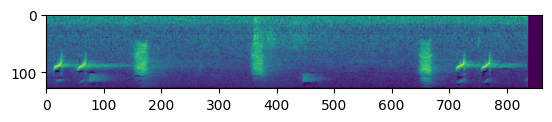

In [6]:
window_size = 5.0
idx = 1001

n_samples = np.ceil((metadata.duration / window_size)).cumsum()

audio_idx = np.where(n_samples >= idx+1)[0].min()
audio_path = os.path.join(PATHS.train_audio, metadata.filename[audio_idx])

i = int(idx - ([0.0] + n_samples.to_list())[audio_idx])
sample = augment_spectrogram(get_spectrogram(audio_path, offset=i*window_size, duration=window_size))

plt.imshow(sample)

In [7]:
class BirdCLEFDataset(Dataset) : 
    def __init__(self, metadata: pd.DataFrame, window_size=5.0) : 
        self.metadata = metadata
        self.window_size = window_size
        
        # Get cumulative number of samples per recording
        self.n_samples = np.ceil((self.metadata.duration / self.window_size)).cumsum()
        
    def __len__(self) : 
        return int(self.n_samples.iloc[-1])
    
    def __getitem__(self, idx) : 
        
        # Find which recording the idx corresponds to
        data_loc = np.where(self.n_samples >= idx+1)[0].min()
        audio_path = os.path.join(PATHS.train_audio, self.metadata.filename.iloc[data_loc])
        
        # Get location within recording
        i = int(idx - ([0.0] + self.n_samples.to_list())[data_loc])
        
        # Load sample
        sample = augment_spectrogram(get_spectrogram(audio_path, offset=i*self.window_size, duration=self.window_size))
        X = torch.Tensor(sample).unsqueeze(0)
        
        # Get label
        nlabel = self.metadata.nlabel.iloc[data_loc]
        y = F.one_hot(torch.as_tensor(nlabel), num_classes=NUM_CATEGORIES).type(torch.float32)
        
        return X, y 

### Splitting training classes according to sample sizes
Around 50% of our training data consists of audio from 22 bird species with 500 samples each. It will be easier to train a small model on these species, where we have a large number of samples, than from some of the other species where we may only have a handful of audio examples. Let us begin here and develop a proof of concept, before moving onto other species. 

In [37]:
vcounts = metadata.primary_label.value_counts()
cat1 = vcounts[vcounts == 500].index.to_list()
cat2 = vcounts[(500 > vcounts) & (vcounts >= 100)].index.to_list()
cat3 = vcounts[(100 > vcounts) & (vcounts >= 25)].index.to_list()
cat4 = vcounts[25 > vcounts].index.to_list()

In [60]:
metadata_1 = metadata[metadata.primary_label.isin(cat1)]
train_metadata_1, val_metadata_1 = train_test_split(metadata_1, test_size=0.2, random_state=42, stratify=metadata_1.nlabel)

train_1 = BirdCLEFDataset(train_metadata_1)
val_1 = BirdCLEFDataset(val_metadata_1)

train_loader_1 = DataLoader(train_1, batch_size=64, shuffle=True)
val_loader_1 = DataLoader(val_1, batch_size=32)

In [61]:
class BirdClassifier (nn.Module):
    # ----------------------------
    # Build the model architecture
    # ----------------------------
    def __init__(self):
        super().__init__()
        conv_layers = []

        # First Convolution Block with Relu and Batch Norm. Use Kaiming Initialization
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)
        init.kaiming_normal_(self.conv1.weight, a=0.1)
        self.conv1.bias.data.zero_()
        conv_layers += [self.conv1, self.relu1, self.bn1]

        # Second Convolution Block
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)
        init.kaiming_normal_(self.conv2.weight, a=0.1)
        self.conv2.bias.data.zero_()
        conv_layers += [self.conv2, self.relu2, self.bn2]

        # Third Convolution Block
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)
        init.kaiming_normal_(self.conv3.weight, a=0.1)
        self.conv3.bias.data.zero_()
        conv_layers += [self.conv3, self.relu3, self.bn3]

        # Fourth Convolution Block
        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        init.kaiming_normal_(self.conv4.weight, a=0.1)
        self.conv4.bias.data.zero_()
        conv_layers += [self.conv4, self.relu4, self.bn4]

        # Linear Classifier
        self.ap = nn.AdaptiveAvgPool2d(output_size=1)
        self.lin = nn.Linear(in_features=64, out_features=NUM_CATEGORIES)

        # Wrap the Convolutional Blocks
        self.conv = nn.Sequential(*conv_layers)
 
    # ----------------------------
    # Forward pass computations
    # ----------------------------
    def forward(self, x):
        # Run the convolutional blocks
        x = self.conv(x)

        # Adaptive pool and flatten for input to linear layer
        x = self.ap(x)
        x = x.view(x.shape[0], -1)

        # Linear layer
        x = self.lin(x)

        # Final output
        return x

In [ ]:
# Define model and loss criterion
model = BirdClassifier()

criterion = nn.CrossEntropyLoss()

# Send to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

print(f"Model running on {device}.")

# Train the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
for epoch in range(10):  # 10 epochs
    for X, y in (pbar := tqdm(train_loader_1)):
        X, y = X.to(device), y.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        outputs = model(X)
        # Compute the loss
        loss = criterion(outputs, y)
        # Backward pass
        loss.backward()
        # Update the model parameters
        optimizer.step()
        
        pbar.set_description(f'Epoch {epoch+1}, Loss: {loss.item():.2f}')
        
    torch.save(model.state_dict(), f"model_{datetime.now().strftime('%y%m%d')}.pt")

Model running on cuda.


Epoch 1, Loss: 3.55:  91%|█████████ | 1232/1352 [58:49<05:37,  2.81s/it] 

In [ ]:
torch.load("model_240501.pt")

In [ ]:
X, y = next(iter(train_dataloader))

In [ ]:
dat = X.detach().numpy()[0]
dat = (dat-dat.mean())/dat.std()

f, (ax1, ax2) = plt.subplots(figsize=(15,10), nrows=2, sharex=True)
ax1.imshow(dat)
datsum=dat.sum(axis=0)
ax2.plot((datsum-datsum.mean())/datsum.std())
ax2.plot([0, dat.shape[1]], [1, 1])
plt.show()

In [ ]:
plt

In [ ]:
# Define model and loss criterion
model = CNN_RNN(NUM_CATEGORIES, 32, 64, 1)
criterion = nn.CrossEntropyLoss()

# Train the model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
X, y = next(iter(dataloader))

In [ ]:
optimizer.zero_grad()

outputs = model(X)

In [ ]:
loss = criterion(outputs, y)

In [ ]:
loss.backward()

In [ ]:
optimizer.step()